# Stage-discharge relation 

- Create time series of stage values using the calibration from `2_calibration`
- Fit a stage-discharge relation for both upper discharge Q1 and lower discharge Q2
- Apply stage-discharge relations and create time series of Q1 and Q2

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000818±2.8e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000456±5.18e-6

958: 9.700806565484955 sd: 9.842223520028694 530: 8.798080978404498
 delta_calib_958: 0.1414169545437396 delta_delta_calib_530: 1.044142541624197 delta_calib_554: 0.006539618492093169

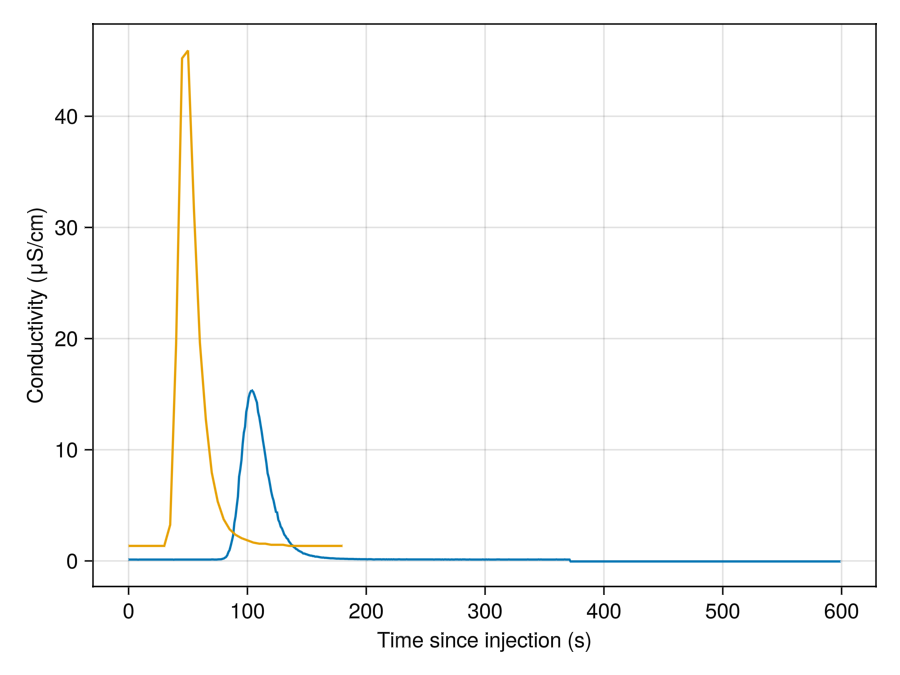

Trace #1 Sensor #2:202.0   Trace #2 Sensor #2:53.0   Trace #3 Sensor #2:45.0   Trace #3 Sensor #1:20.0   Trace #4 Sensor #2:52.0   Trace #4 Sensor #1:40.0   Trace #5 Sensor #2:116.0   Trace #5 Sensor #1:115.0   Trace #6 Sensor #2:46.0   Trace #6 Sensor #1:35.0   Trace #7 Sensor #2:45.0   Trace #7 Sensor #1:30.0   Trace #8 Sensor #2:52.0   Trace #8 Sensor #1:20.0   Trace #9 Sensor #2:200.0   Trace #9 Sensor #1:155.0   Trace #10 Sensor #2:45.0   Trace #10 Sensor #1:50.0   

In [4]:
using NBInclude
@nbinclude("4_process_traces.ipynb") # load previous work
using CSV, DataFrames
using MonteCarloMeasurements, Distributions
using GLMakie
using Dates

## Stage-discharge relation and continuous Q

### Time series of stage
Match the dicts with air pressure and water pressure on time 

Subtract air pressure from water pressure -> gives pressure head

Filter for periods where sensor was out of water

Correct for jumps where sensor moved in the water

In [3]:
#matches dicts with water and air pressure on the same time. stage is calculated as air pressure (m H20) - water pressure (m H20) 

#match dicts with water and air pressure on date

#creates temporary dict with :t as key and :press as value and round them to the nearest minute

function round_dict(dictname) #creates dict with with :t as key and :press as value
dict_rounded = Dict() #initialise dict
j = 1
for i in dictname[:t]
        # Round to the nearest minute
        rounded_i = Dates.DateTime(
        year(i), month(i), day(i), hour(i), minute(i), 0
) + Dates.Minute(round(Int, second(i) / 60))
        
    dict_rounded[rounded_i] = dictname[:press][j]
    j += 1
end
return dict_rounded
end

#add uncertainties to pressure values
p_uncert = 0.0005 * (2-0.8)*100/9.81  #uncertainty of pressure sensors
d_sd[:press] = d_sd[:press] .+ ± p_uncert
d_554_calib[:press] = d_554_calib[:press] .+ ± p_uncert
d_530_calib[:press] = d_530_calib[:press] .+ ± p_uncert
d_958_calib[:press] = d_958_calib[:press] .+ ± p_uncert

#run round_dict for all dicts
d_sd_rounded = round_dict(d_sd)
d_554_rounded = round_dict(d_554_calib)
d_530_rounded = round_dict(d_530_calib)
d_958_rounded = round_dict(d_958_calib)

# Find common keys (dates) between the two dictionaries
function calc_stage(dict1, dict2 = d_sd_rounded)
common_dates = intersect(keys(dict1), keys(dict2))
stage_date = Dict()

for date in common_dates
    stage_date[date] = (dict1[date] - dict2[date])
end
return(stage_date)
end

#run calc_stage for all dicts and sort by date, output stores: date => stage [m]
d_554_stage = sort(calc_stage(d_554_rounded))
d_530_stage = sort(calc_stage(d_530_rounded))
d_958_stage = sort(calc_stage(d_958_rounded))

function change_keys(d) #makes :t and :s the new keys
    stage_array = []
    t_array = []
    for i in keys(d)
        push!(stage_array, d[i])
        push!(t_array, i)
    end
    s = Dict()
    s[:s] = stage_array
        s[:t] = t_array
    return s
end

#output dicts with :t and :s as new keys
sq1 = change_keys(d_554_stage)
sq2 = change_keys(d_530_stage)
sq4 = change_keys(d_958_stage);

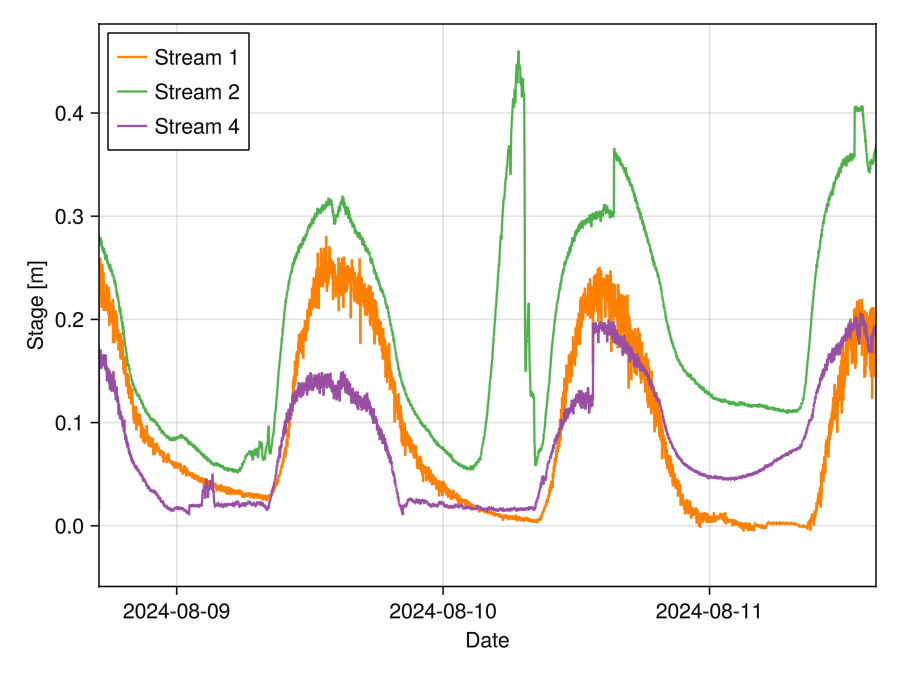

In [4]:
#plot stage
Makie.inline!(true)
using Dates
fig = Figure()
ax = Axis(fig[1,1], xlabel = "Date", ylabel = "Stage [m]")
#colors = [:red, :blue, :green, :darkorange, :pink]
colors = [ "#ff7f00", "#4daf4a" , "#ffff33","#984ea3", "#377eb8"]
lines!(ax, sq1[:t], sq1[:s], label = "Stream 1", color = colors[1])
lines!(ax, sq2[:t], sq2[:s], label = "Stream 2", color = colors[2])
lines!(ax, sq4[:t], sq4[:s], label = "Stream 4", color = colors[4])

xmin = DateTime(2024, 8, 8, 17, 00, 0) #period when the sensors were measuring
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :lt)
display(fig)
save("../data/products/plots/final/Stage-Time-raw_final.png", fig)
colors = [:red, :blue, :green, :darkorange, :pink];

In [5]:
#filter values where pressure sensor presumably was out of water 
#correct offset where sensor suddenly moved

unsafe_comparisons(true) #reduces particles to floating numbers (using the mean) for comparison reasons
#filter where stage 4 < 5cm and  remove time period from 2024-08-09 02:00:00 to 04:00:00
t1 = DateTime(2024, 8, 9, 2, 00, 0)
t2 = DateTime(2024, 8, 9, 4, 00, 0)
for i in 1:length(sq4[:s]) 
        if sq4[:s][i] < 0.04
            sq4[:s][i] = NaN ± 0.0
        end
        if (sq4[:t][i] > t1) && (sq4[:t][i] < t2)
            sq4[:s][i] = NaN ± 0.0
        end
end

#remove stage 1 for time period from 2024-08-10 22:00:00 to 2024-08-11 09:00:00
t3 = DateTime(2024, 8, 10, 22, 00, 0)
t4 = DateTime(2024, 8, 11, 9, 00, 0)
for i in 1:length(sq1[:s]) 
        if (sq1[:t][i] > t3) && (sq1[:t][i] < t4)
            sq1[:s][i] = NaN ± 0.0
        end
end

"""
#remove nighttime peak of 2 -> remove time periode from 2024-08-10 02:00:00 to 08:30:00
t5 = DateTime(2024, 8, 10, 2, 00, 0)
t6 = DateTime(2024, 8, 10, 8, 30, 0)
for i in 1:length(sq2[:s]) 
        if (sq2[:t][i] > t5) && (sq2[:t][i] < t6)
            sq2[:s][i] = NaN
        end
end
"""

#correct offset
#stage 2: 0.304 at 2024-08-10 15:23, jump to 0.3666 at 15:25
#stage 4: 0.1254 at 2024-08-10 13:30, jump to 0.1968 at 13:31


t_jump2 = DateTime(2024, 8, 10, 15, 23, 0)
t_jump2_after = DateTime(2024, 8, 10, 15, 25, 0)
delta_jump2 = sq2[:s][sq2[:t] .== t_jump2_after] - sq2[:s][sq2[:t] .== t_jump2]

sq2[:s][sq2[:t] .> t_jump2] = sq2[:s][sq2[:t] .> t_jump2] .- delta_jump2


t_jump4 = DateTime(2024, 8, 10, 13, 30, 0)
t_jump4_after = DateTime(2024, 8, 10, 13, 31, 0)
delta_jump4 = sq4[:s][sq4[:t] .== t_jump4_after] - sq4[:s][sq4[:t] .== t_jump4]
sq4[:s][sq4[:t] .> t_jump4] = sq4[:s][sq4[:t] .> t_jump4] .- delta_jump4;

[ Info: Unsafe comparisons using the function `pmean` has been enabled globally. Use `@unsafe` to enable in a local expression only or `unsafe_comparisons(false)` to turn off unsafe comparisons


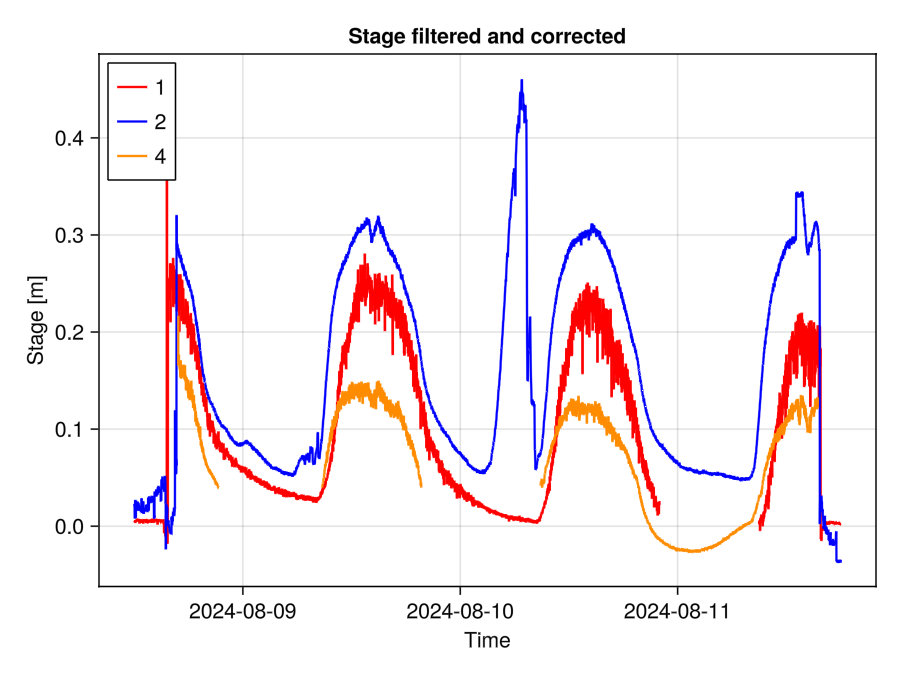

In [6]:
#plot filtered stage
Makie.inline!(true)
fig = Figure()
ax = Axis(fig[1,1], title = "Stage filtered and corrected", xlabel = "Time", ylabel = "Stage [m]")
colors = [:red, :blue, :green, :darkorange, :pink]
lines!(ax, sq1[:t], sq1[:s], label = "1", color = colors[1])
lines!(ax, sq2[:t], sq2[:s], label = "2", color = colors[2])
lines!(ax, sq4[:t], sq4[:s], label = "4", color = colors[4])

xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :lt)
fig

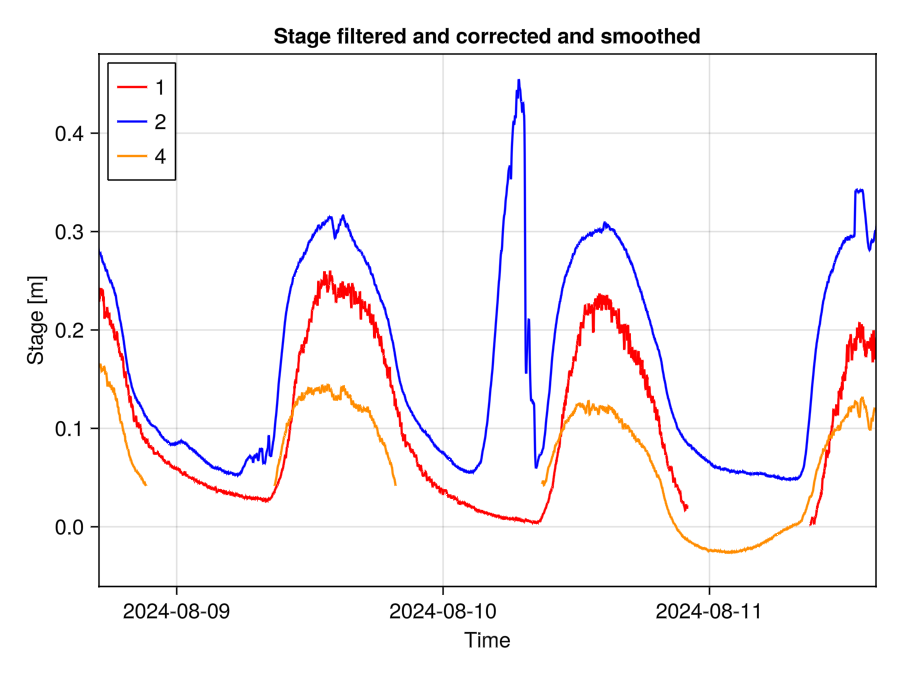

GLMakie.Screen(...)

In [7]:
#plot smoothed stage

function moving_average(y, window_size = 5)
    return [mean(y[max(1, i-window_size+1):i]) for i in 1:length(y)]
end

Makie.inline!(true)
using Dates
fig = Figure()
ax = Axis(fig[1,1], title = "Stage filtered and corrected and smoothed", xlabel = "Time", ylabel = "Stage [m]")
colors = [:red, :blue, :green, :darkorange, :pink]
lines!(ax, sq1[:t], moving_average(sq1[:s]), label = "1", color = colors[1])
lines!(ax, sq2[:t], moving_average(sq2[:s]), label = "2", color = colors[2])
lines!(ax, sq4[:t], moving_average(sq4[:s]), label = "4", color = colors[4])

xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :lt)
display(fig)

### Find parameters of linear stage-discharge-relation 
Load output file from `4_process_traces`and assign uncertainties to it using MonteCarloMeasurements. Note: the data type `Particles` by the MonteCarloMeasurements did not work with all functions and plotting function. This can be worked around using `mean_object()`.

Create Dict with values from stage and discharge when we did the salt dilution traces

Function based on a modification of the  calibration functions we used for the conductivity-salt_conc-relation. This function can handle uncertainties using MonteCarloMeasurements


In [8]:
# Read output file from 4_process_traces.ipynb with discharges und Runtimes
traces_full = CSV.read("../data/products/processed_traces/output_Trapez.csv", DataFrame)
traces_full.Date = Date.(traces_full.Date, "dd.mm.yyyy")
traces_full.t_inj = DateTime.(traces_full.Date, traces_full."Injection time")
traces = traces_full[:, ["Location", "t_inj", "Q1", "Q2", "t1", "t2"]]
traces[10, "Location"] = "5"
traces.Location = parse.(Int, traces.Location)
rename!(traces, [:loc, :t_inj, :Q1, :Q2, :t1, :t2])
traces.t1 = traces.t1 ± 10 #big uncertainty because comes from time of peak with sampling every 5s only & there was some drift in synchronisation of internal time and watch time
traces.t2 = traces.t2 ± 2
tracesQ1_helper = copy(traces.Q1) #helper vector since the uncertainty cannot be NaN and i am using relative uncertainties -> put those uncertainties to 0 instead of NaN
tracesQ1_helper[1:2] = [0.0, 0.0]
traces.Q1 = traces.Q1 .± tracesQ1_helper.*0.1
traces.Q2 = traces.Q2 .± traces.Q2.*0.1
traces = sort(traces, :loc);

Row,loc,t_inj,Q1,Q2,t1,t2
,Int64,DateTime,Particle…,Particle…,Particle…,Particle…
1,1,2024-08-09T11:41:00,0.47 ± 0.047,0.59 ± 0.059,50.1 ± 9.8,104.0 ± 2.0
2,1,2024-08-09T16:25:06,0.61 ± 0.061,0.77 ± 0.077,29.8 ± 9.9,88.0 ± 2.0
3,1,2024-08-11T09:18:35,0.065 ± 0.0065,0.074 ± 0.0074,115.0 ± 10.0,293.0 ± 2.0
4,2,2024-08-09T09:32:50,NaN ± NaN,0.084 ± 0.0084,NaN ± NaN,544.0 ± 2.0
5,2,2024-08-09T14:15:14,0.14 ± 0.014,0.22 ± 0.022,160.0 ± 9.9,367.0 ± 2.0
6,3,2024-08-09T10:11:00,NaN ± NaN,0.18 ± 0.018,NaN ± NaN,130.0 ± 2.1
7,3,2024-08-09T14:59:25,0.23 ± 0.023,0.29 ± 0.029,40.3 ± 9.9,99.1 ± 2.0
8,4,2024-08-09T10:42:30,0.15 ± 0.015,0.21 ± 0.021,15.1 ± 9.8,121.0 ± 2.0
9,4,2024-08-09T15:40:05,0.22 ± 0.022,0.25 ± 0.025,19.9 ± 9.8,121.0 ± 2.0


sd-rel for lower discharge Q2

In [9]:
#match measured discharged with pressure head of that time, output sd_rel_values

#specific helper functions
function Qvalue(streamx, i, Q_i) #read discharge value (Q2) from dataframe traces
    Q = traces[[traces.loc .== streamx][1], Q_i][i]
    return Q
end

function rounddt_streamx(streamx) #extracts all t_inj from measurements from one stream and rounds them to the nearest minute
    t = DateTime[]
    for i in 1:length(traces.t_inj[traces.loc .== streamx])
            rounded_i = Dates.DateTime(
            year(traces.t_inj[traces.loc .== streamx][i]), month(traces.t_inj[traces.loc .== streamx][i]), day(traces.t_inj[traces.loc .== streamx][i]), hour(traces.t_inj[traces.loc .== streamx][i]), minute(traces.t_inj[traces.loc .== streamx][i]), 0
    ) + Dates.Minute(round(Int, second(traces.t_inj[traces.loc .== streamx][i]) / 60))
        push!(t, rounded_i)
    end
    return t
end

function svalue(dictname, streamx, i) #read average stage value of the time t_inj until 5 mins later from the sq dicts. input dictname, stream number, i = i'th measurement of that stream
    s_temp = 0 ± 0
    for j in [0, 1, 2, 4, 5]
        s_temp = s_temp + dictname[:s][dictname[:t] .== (rounddt_streamx(streamx)[i] + Minute(j))][1]
    end
    s = s_temp / 5
    return s
end

sd_rel_values = Dict{Int64, Matrix{Particles}}(958=> ## stream 4
                             # first calibration
                          [ Qvalue(4,1, "Q2") svalue(sq4, 4, 1) ## [discharge CTD (m^3/s, output from notebook 4) water pressure head (m H2O, read out from plot manually) - air pressure head (m H2O, read out from CSV 554 as mbar and converted right here) 
                            Qvalue(4,2, "Q2") svalue(sq4, 4, 2)],
                            
                    530=> ## stream 2
                            [ Qvalue(2,1, "Q2") svalue(sq2, 2, 1) ## First row needs to be the background reading! First calib with 10g/L -> actual volumes times 10
                              Qvalue(2,2, "Q2") svalue(sq2, 2, 2)], #weird shape of curve -> probably clouds or smth, possible looking at global radiation from met data
                            
                    554 => ## stream 1
                           [Qvalue(1,1, "Q2") svalue(sq1, 1, 1) 
                            Qvalue(1,2, "Q2") svalue(sq1, 1, 2)
                            Qvalue(1,3, "Q2") svalue(sq1, 1, 3)],#out of water? -> filter data from night from 554!
                            );

adding artificial values

In [11]:
#add the point min(stage stream 4) corresponds to discharge = 0.05 to improve the calibration
# it's a guess but better than what we have for now, since values now give me a negative gradient of the fit
# output with only the two measured values: Estimated linear fit sensor 958: Q(s) = a + b*stage with a = 3.58 ± 2.8, b = -26.2 ± 21.0

xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)

#currently in use!
artif_sd958 = [0.02 ± 0.002  minimum(sq4[:s][(.!isnan.(mean_object(sq4[:s]))) .&& (sq4[:t] .> xmin)  .&& (sq4[:t] .< xmax)])]
sd_rel_values[958] = vcat(sd_rel_values[958], artif_sd958)

#sensor 530 (stream 2) was clearly never out of the water if you look at the stage timeseries -> minimum stage value corresponds to a small (arbitrary) discharge
artif_sd530 = [0.02 ± 0.002  minimum(sq2[:s][(.!isnan.(mean_object(sq2[:s]))) .&& (sq2[:t] .> xmin)  .&& (sq2[:t] .< xmax)])]
sd_rel_values[530] = vcat(sd_rel_values[530], artif_sd530);

In [12]:
#2nd fit with artificial value added 

#linear relation q(s) using the same function as for the calibration, adapted for MC measurements
Makie.inline!(true)
fig2 = Figure()

id = [554, 530, 958]
streamno = [1, 2, 4]
sd_rel_fn_param = Dict()

for i in range(1,3)
    cali = sd_rel_values[id[i]]
    discharge = cali[:,1]
    stage = cali[:,2]
    # Fit line using https://github.com/JuliaOpt/LsqFit.jl
    #fn(stage, p) = p[1] .+ p[2]*stage ## p[1]==a, p[2]==b
    model = (stage,p) -> p[1] .+ stage.*p[2] 
    para_weights = [0.5, 0.5] ## equal weights to parameters
    fit = curve_fit_MCMeasurements(model, stage, discharge, para_weights)
    #errors = margin_error(fit, 1-0.95), no point with two data points
    println("""
    Estimated linear fit sensor $(id[i]): Q(s) = a + b*stage with
     a = $(round(fit[1],sigdigits=3)), b = $(round(fit[2],sigdigits=3))
    """)
    sd_rel_fn_param[id[i]] = [fit[1], fit[2]]

    print(mean_object(stage))
    Axis(fig2[i, 1], title="Stream $(streamno[i])",
        xlabel=L"Stage $[m]$",
        ylabel=L"Discharge $[m^3s^{-1}$]")
    if id[i] != 554
       scatter!(mean_object(stage), mean_object(discharge), color = [Makie.wong_colors()[1], Makie.wong_colors()[1], Makie.wong_colors()[6]])
    else
        scatter!(mean_object(stage), mean_object(discharge))
    end

    delta_fn = model(stage, fit)
    #calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0.2
    """for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")"""

    # Now plot the line of best fit:
    #readouts = [i for i in 0:0.01:0.2]
    # (lines! plots a line)
    lines!(mean_object(stage), model((mean_object(stage)), mean_object(fit)), label="line of best fit")
    
    
end
fig2
save("../data/products/plots/final/CalibrationQ2_final.png", fig2)

#fit sensor 958 without artificially added value: 
#fit sensor 958 with min -> Q = 0.05: Q(s) = a + b*stage with a = 0.0853 ± 0.011, b = 1.13 ± 0.11
#fit sensor 958 with min -> Q = 0.00: Q(s) = a + b*stage with a = 0.0452 ± 0.013, b = 1.45 ± 0.1
#fit sensor 958 with min -> Q = 0.10: Q(s) = a + b*stage with a = 0.126 ± 0.011, b = 0.817 ± 0.12

#fit sensor 530 without artif:  a + b*stage with a = -0.173 ± 0.05, b = 1.33 ± 0.23
#fit sensor 530 with min -> q = 0.05: Q(s) =a + b*stage with a = 0.0457 ± 0.0063, b = 0.467 ± 0.062
#fit sensor 530 with min -> q = 0.02: Q(s) = a + b*stage with a = 0.0203 ± 0.0056, b = 0.567 ± 0.06

Estimated linear fit sensor 554: Q(s) = a + b*stage with
 a = 0.0524 ± 0.028, b = 2.89 ± 0.25

[0.19711250330350993, 0.2398566419375575, 0.005514134292297797]Estimated linear fit sensor 530: Q(s) = a + b*stage with
 a = -0.031 ± 0.01, b = 0.776 ± 0.082

[0.19400186884132273, 0.296603295956511, 0.04695599728168976]Estimated linear fit sensor 958: Q(s) = a + b*stage with
 a = 0.0563 ± 0.012, b = 1.36 ± 0.11

[0.12841593517574787, 0.12688892192396375, -0.026564696832406476]

sd-relation for upper discharge Q1 (measured by the WTW)

In [13]:
sd_rel1_values = Dict{Int64, Matrix{Particles}}(958=> ## stream 4
                          [ Qvalue(4,1, "Q1") svalue(sq4, 4, 1) ## [discharge CTD (m^3/s, output from notebook 4) water pressure head (m H2O, read out from plot manually) - air pressure head (m H2O, read out from CSV 554 as mbar and converted right here) 
                            Qvalue(4,2, "Q1") svalue(sq4, 4, 2)],
                            
                    530=> ## stream 2
                            [ Qvalue(2,1, "Q1") svalue(sq2, 2, 1) ## First row needs to be the background reading! First calib with 10g/L -> actual volumes times 10
                              Qvalue(2,2, "Q1") svalue(sq2, 2, 2)], #weird shape of curve -> probably clouds or smth, possible looking at global radiation from met data
                            
                    554 => ## stream 1
                           [Qvalue(1,1, "Q1") svalue(sq1, 1, 1) 
                            Qvalue(1,2, "Q1") svalue(sq1, 1, 2)
                            Qvalue(1,3, "Q1") svalue(sq1, 1, 3)],#out of water? -> filter data from night from 554!
                            );

add artificial values

Estimated linear fit sensor 554: Q(s) = a + b*stage with
 a = 0.0482 ± 0.022, b = 2.26 ± 0.2

Estimated linear fit sensor 958: Q(s) = a + b*stage with
 a = 0.0487 ± 0.0096, b = 1.07 ± 0.087

Estimated linear fit sensor 530: Q(s) = a + b*stage with
 a = 0.0334 ± 0.0039, b = 0.36 ± 0.043



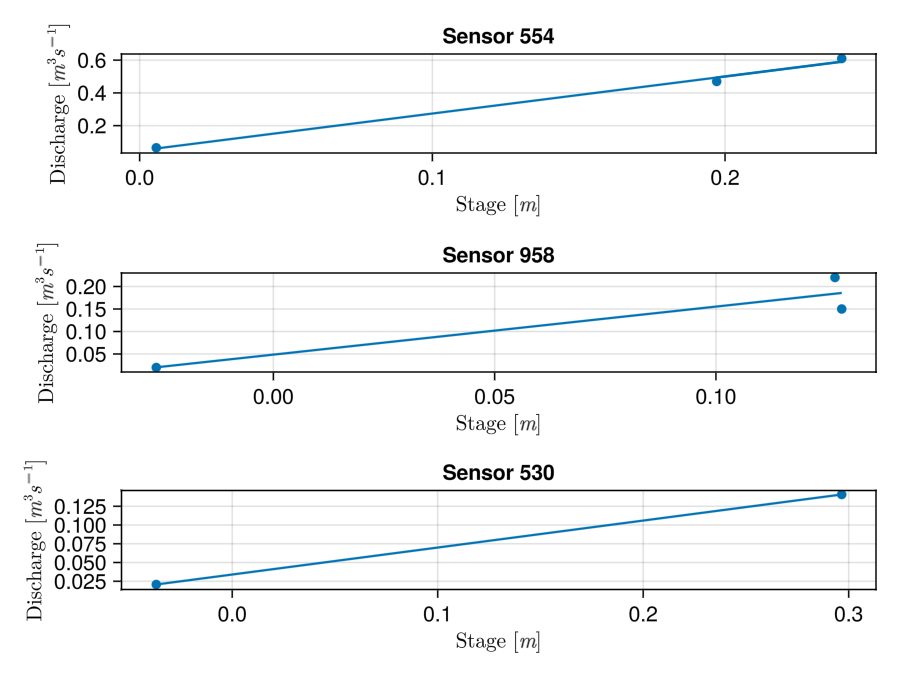

In [15]:
#add the point min(stage stream 4) corresponds to discharge = 0.05 to improve the calibration
# it's a guess but better than what we have for now, since values now give me a negative gradient of the fit
# output with only the two measured values: Estimated linear fit sensor 958: Q(s) = a + b*stage with a = 3.58 ± 2.8, b = -26.2 ± 21.0

#currently in use!
artif_sd = [0.02 ± 0.002  minimum(sq4[:s][.!isnan.(mean_object(sq4[:s]))])]
sd_rel1_values[958] = vcat(sd_rel1_values[958], artif_sd)

artif_sd2 = [0.02 ± 0.002, minimum(sq2[:s][.!isnan.(mean_object(sq2[:s]))])]
sd_rel1_values[530][1, :] = artif_sd2 #replace row containing NaN

#linear relation q(s) using the same function as for the calibration, adapted for MC
Makie.inline!(true)
fig2 = Figure()

id = [554, 958, 530] #without 530 because there is only one non-NaN value for the discharge
sd_rel1_fn_param = Dict()

for i in range(1,3)
    cali = sd_rel1_values[id[i]]
    discharge = cali[:,1]
    stage = cali[:,2]
    # Fit line using https://github.com/JuliaOpt/LsqFit.jl
    #fn(stage, p) = p[1] .+ p[2]*stage ## p[1]==a, p[2]==b
    model = (stage,p) -> p[1] .+ stage.*p[2] 
    para_weights = [0.5, 0.5] ## equal weights to parameters
    fit = curve_fit_MCMeasurements(model, stage, discharge, para_weights)
    #errors = margin_error(fit, 1-0.95), no point with two data points
    println("""
    Estimated linear fit sensor $(id[i]): Q(s) = a + b*stage with
     a = $(round(fit[1],sigdigits=3)), b = $(round(fit[2],sigdigits=3))
    """)
    sd_rel1_fn_param[id[i]] = [fit[1], fit[2]]

    
    Axis(fig2[i, 1], title="Sensor $(id[i])",
        xlabel=L"Stage $[m]$",
        ylabel=L"Discharge $[m^3s^{-1}$]")
    scatter!(mean_object(stage), mean_object(discharge))
    delta_fn = model(stage, fit)
    #calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0.2
    """for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")"""

    # Now plot the line of best fit:
    #readouts = [i for i in 0:0.01:0.2]
    # (lines! plots a line)
    lines!(mean_object(stage), model(mean_object(stage), mean_object(fit)), label="line of best fit")
    
    
end
fig2

### Implement Stage-Discharge relation and plot it

In [17]:
#apply paramaters from stage-discharge relation to the dicts with the stage
sq1[:q2] = sd_rel_fn_param[554][1] .+ sd_rel_fn_param[554][2].*sq1[:s] #discharge of 554 aka stream 1
sq2[:q2] = sd_rel_fn_param[530][1] .+ sd_rel_fn_param[530][2].*sq2[:s] #530
sq4[:q2] = sd_rel_fn_param[958][1] .+ sd_rel_fn_param[958][2].*sq4[:s] #958

sq1[:q1] = sd_rel1_fn_param[554][1] .+ sd_rel1_fn_param[554][2].*sq1[:s]
sq2[:q1] = sd_rel1_fn_param[530][1] .+ sd_rel1_fn_param[530][2].*sq2[:s]
sq4[:q1] = sd_rel1_fn_param[958][1] .+ sd_rel1_fn_param[958][2].*sq4[:s];

In [19]:
#smoothed lines
s1q1_smoothed = moving_average(sq1[:q1])
s1q2_smoothed = moving_average(sq1[:q2])
s2q1_smoothed = moving_average(sq2[:q1])
s2q2_smoothed = moving_average(sq2[:q2])
s4q1_smoothed = moving_average(sq4[:q1])
s4q2_smoothed = moving_average(sq4[:q2]);

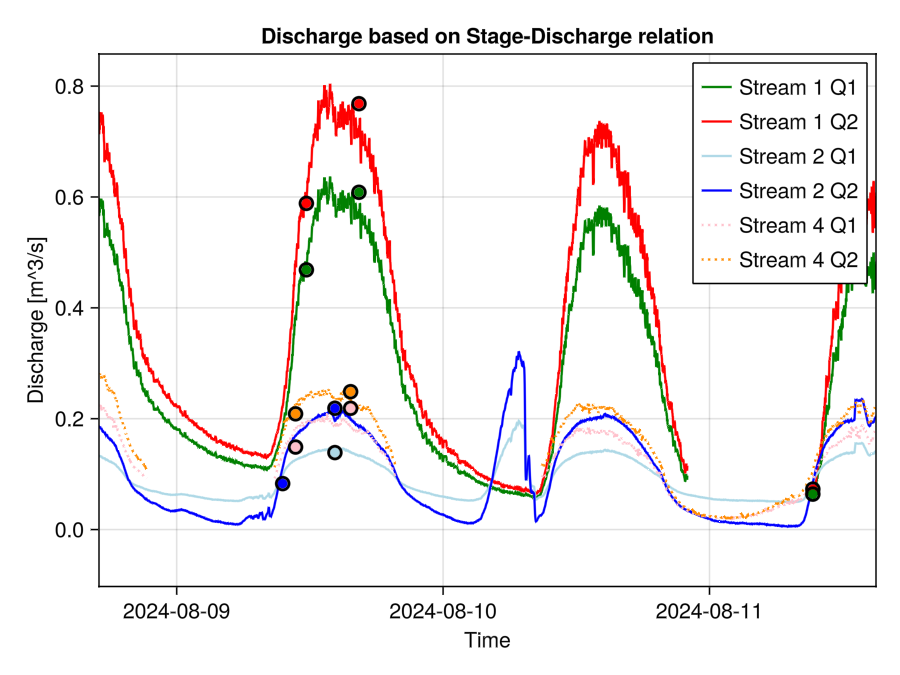

In [20]:
#plot discharge time series and measured discharges

Makie.inline!(false)
fig = Figure()
colors = [:red, :blue, :green, :darkorange, :pink]
ax = Axis(fig[1,1], title = "Discharge based on Stage-Discharge relation", xlabel = "Time", ylabel = "Discharge [m^3/s]")
lines!(ax, sq1[:t], s1q1_smoothed, label = "Stream 1 Q1", color = colors[3])
lines!(ax, sq1[:t], s1q2_smoothed, label = "Stream 1 Q2", color = colors[1])
lines!(ax, sq2[:t], s2q1_smoothed, label = "Stream 2 Q1", color = :lightblue)
lines!(ax, sq2[:t], s2q2_smoothed, label = "Stream 2 Q2", color = colors[2])
lines!(ax, sq4[:t], s4q1_smoothed, label = "Stream 4 Q1", color = colors[5], linestyle = :dot)
lines!(ax, sq4[:t], s4q2_smoothed, label = "Stream 4 Q2", color = colors[4], linestyle = :dot)

#band!(ax, x, y_mean .- y_std, y_mean .+ y_std, color=:blue, transparency=true, alpha=0.2, label="Uncertainty")

for i in 1:length(traces.loc)
    if traces.loc[i] != 3 && traces.loc[i] != 5 #&& traces.loc[i] != 4
        scatter!(traces.t_inj[i], mean_object(traces.Q2[i]), color = colors[traces.loc[i]], strokecolor = :black, strokewidth = 2)
    end

    if traces.loc[i] == 1 
        scatter!(traces.t_inj[i], mean_object(traces.Q1[i]), color = colors[3], strokecolor = :black, strokewidth = 2)
    end
    if traces.loc[i] == 4
        scatter!(traces.t_inj[i], mean_object(traces.Q1[i]), color = colors[5], strokecolor = :black, strokewidth = 2)
    end

    if traces.loc[i] == 2
        scatter!(traces.t_inj[i], mean_object(traces.Q1[i]), color = :lightblue, strokecolor = :black, strokewidth = 2)
    end
end

#scatter!(sd_rel1_values[554][1, :])


xmin = DateTime(2024, 8, 8, 17, 00, 0)
xmax = DateTime(2024, 8, 11, 15, 00, 0)
xlims!(ax, xmin, xmax)
#ylims!(ax, 9.5, 10)

axislegend(ax, position = :rt)
fig
#save("../data/products/plots/Q artif value Q = 0.02 for 4 and 2both.png", fig)
#save("Q from sd without artif value for 4.png", fig)